In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
from torch.nn.utils import clip_grad_value_
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random

In [13]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, latent_dim):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim) #mean of latent dist
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim) #log var of latent dist

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        h = F.relu(self.enc_fc1(combined))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

# Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        logits = self.layer2(h)
        return logits

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super().__init__()
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        combined = torch.cat([z, y], dim=-1)
        h = F.relu(self.dec_fc1(combined))
        x_hat = self.dec_fc2(h)
        return x_hat

In [15]:
# SSL model
class SSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, learning_rate):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.classifier = Classifier(input_dim, hidden_dim, num_classes)
        self.encoder = Encoder(input_dim, num_classes, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, hidden_dim, input_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def classify(self, x):
        return self.classifier(x)

    def encode(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z, y):
        return self.decoder(z, y)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_l, y_l, x_u):
        """
        x_l: labeled data
        y_l: labels
        x_u: unlabeled data

        """
        # Obtain classifier scores for labeled and unlabeled data.
        scores_l = self.classifier(x_l)
        scores_u = self.classifier(x_u)
        y_u_prob = F.softmax(scores_u, dim=1)

        # Labeled part
        y_l_onehot = F.one_hot(y_l, self.num_classes).float()
        z_l, mu_l, logvar_l = self.encode(x_l, y_l_onehot)
        x_recon = self.decode(z_l, y_l_onehot)

        # Unlabeled part
        loss_u_components = []
        for i in range(self.num_classes):
            y_u = torch.full((x_u.size(0),), i, dtype=torch.long, device=x_u.device)
            y_u_onehot = F.one_hot(y_u, self.num_classes).float()
            z_u, mu_u, logvar_u = self.encode(x_u, y_u_onehot)
            x_recon_u = self.decode(z_u, y_u_onehot)

            # Compute ELBO loss for this label.
            loss_u = self.elbo_loss(x_u, x_recon_u, mu_u, logvar_u)
            loss_u_components.append(loss_u.unsqueeze(1))

        loss_u_stack = torch.cat(loss_u_components, dim=1)

        # Weight the losses by the classifier’s predicted probabilities.
        loss_u = torch.sum(y_u_prob * (loss_u_stack + torch.log(y_u_prob + 1e-8)), dim=1)

        # Total Loss
        classification_loss = F.cross_entropy(scores_l, y_l)
        labeled_loss = self.elbo_loss(x_l, x_recon, mu_l, logvar_l)
        unlabeled_loss = loss_u.mean()

        total_loss = labeled_loss.mean() + unlabeled_loss + 0.1 * classification_loss

        return total_loss, scores_u

    def elbo_loss(self, x, x_recon, mu, logvar):
        # KL divergence between latent distribution and standard normal
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=1)
        return recon_loss + kld

    def train_step(self, x_l, y_l, x_u):
        # Training loop
        self.optimizer.zero_grad()
        loss, _ = self.forward(x_l, y_l, x_u)
        loss.backward()
        #clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        # Prediction
        with torch.no_grad():
            scores = self.classifier(x)
        return torch.argmax(scores, dim=1)

    def visualize_latent_tsne(self, dataloader, num_samples=1000):
        self.eval()
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(self.device)
                y_onehot = F.one_hot(y, self.num_classes).float().to(self.device)

                # Get latent representation
                z, _, _ = self.encode(x, y_onehot)

                latents.append(z.cpu())
                labels.append(y.cpu())

                if sum(len(l) for l in latents) >= num_samples:
                    break

        latents = torch.cat(latents)[:num_samples].numpy()
        labels = torch.cat(labels)[:num_samples].numpy()

        # Perform T-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latents)

        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels,
                            cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('T-SNE Visualization of Latent Space')
        plt.show()

    def generate_conditional_samples(self, num_samples=10):
        self.eval()
        samples = []

        with torch.no_grad():
            for c in range(self.num_classes):
                # Class labels
                y = torch.full((num_samples,), c, device=self.device)
                y_onehot = F.one_hot(y, self.num_classes).float()

                # Sample the latent variable
                z = torch.randn(num_samples, self.latent_dim, device=self.device)

                # Generate images (latent -> image)
                x_gen = torch.sigmoid(self.decoder(z, y_onehot))
                samples.append(x_gen.cpu())

        # Plot grid: CIFAR-10 images are 32x32 with 3 channels.
        fig, axs = plt.subplots(self.num_classes, num_samples,
                                figsize=(num_samples * 2, self.num_classes * 2))

        for row in range(self.num_classes):
            for col in range(num_samples):
                # Reshape generated vector into (3, 32, 32)
                img = samples[row][col].view(3, 32, 32)
                # Permute to (32, 32, 3) for imshow
                img = img.permute(1, 2, 0).numpy()
                axs[row, col].imshow(img)
                axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()



## Using all unlabeled dataset

Using device: cuda
Files already downloaded and verified
Starting training with 100 labels and 49900 without labels...
Epoch [1/100], Average Loss: 2111.2128
Epoch [2/100], Average Loss: 2048.3218
Epoch [3/100], Average Loss: 2027.4086
Epoch [4/100], Average Loss: 2014.7737
Epoch [5/100], Average Loss: 2011.5833
Epoch [6/100], Average Loss: 2000.1077
Epoch [7/100], Average Loss: 1993.2170
Epoch [8/100], Average Loss: 1985.5995
Epoch [9/100], Average Loss: 1976.7931
Epoch [10/100], Average Loss: 1971.4659
Epoch [11/100], Average Loss: 1961.8878
Epoch [12/100], Average Loss: 1954.3955
Epoch [13/100], Average Loss: 1955.5805
Epoch [14/100], Average Loss: 1948.1249
Epoch [15/100], Average Loss: 1939.8981
Epoch [16/100], Average Loss: 1939.6135
Epoch [17/100], Average Loss: 1932.2723
Epoch [18/100], Average Loss: 1933.4935
Epoch [19/100], Average Loss: 1927.9409
Epoch [20/100], Average Loss: 1923.9725
Epoch [21/100], Average Loss: 1921.7250
Epoch [22/100], Average Loss: 1920.3004
Epoch [23/

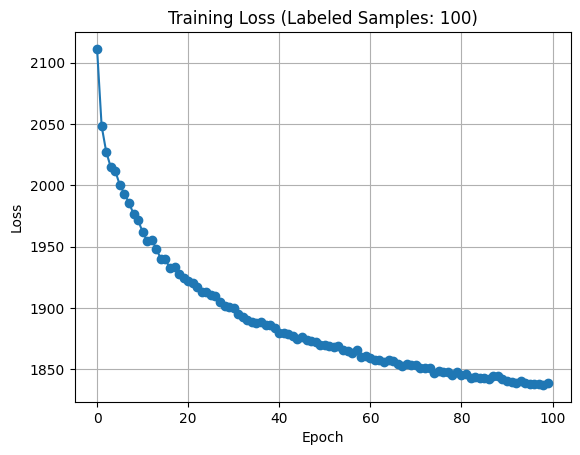

Files already downloaded and verified
Test Accuracy (100 labels): 11.34%


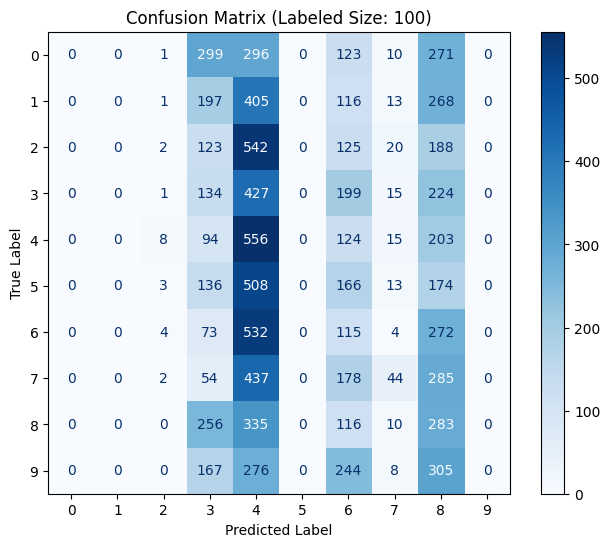

----------------------------------------------------------------
Starting training with 1000 labels and 49000 without labels...
Epoch [1/100], Average Loss: 2063.1389
Epoch [2/100], Average Loss: 1992.0753
Epoch [3/100], Average Loss: 1960.6167
Epoch [4/100], Average Loss: 1941.2585
Epoch [5/100], Average Loss: 1928.4079
Epoch [6/100], Average Loss: 1917.7681
Epoch [7/100], Average Loss: 1908.3685
Epoch [8/100], Average Loss: 1901.8398
Epoch [9/100], Average Loss: 1898.3908
Epoch [10/100], Average Loss: 1893.7480
Epoch [11/100], Average Loss: 1890.1358
Epoch [12/100], Average Loss: 1887.9839
Epoch [13/100], Average Loss: 1884.2554
Epoch [14/100], Average Loss: 1880.2804
Epoch [15/100], Average Loss: 1878.6701
Epoch [16/100], Average Loss: 1876.2010
Epoch [17/100], Average Loss: 1874.4803
Epoch [18/100], Average Loss: 1873.0730
Epoch [19/100], Average Loss: 1872.4403
Epoch [20/100], Average Loss: 1869.8162
Epoch [21/100], Average Loss: 1868.5346
Epoch [22/100], Average Loss: 1867.1527
E

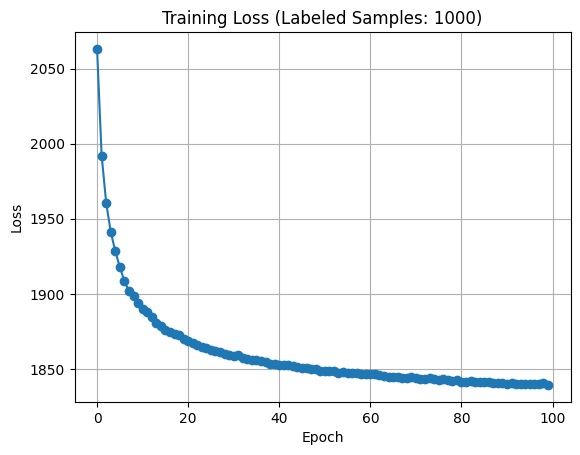

Files already downloaded and verified
Test Accuracy (1000 labels): 23.64%


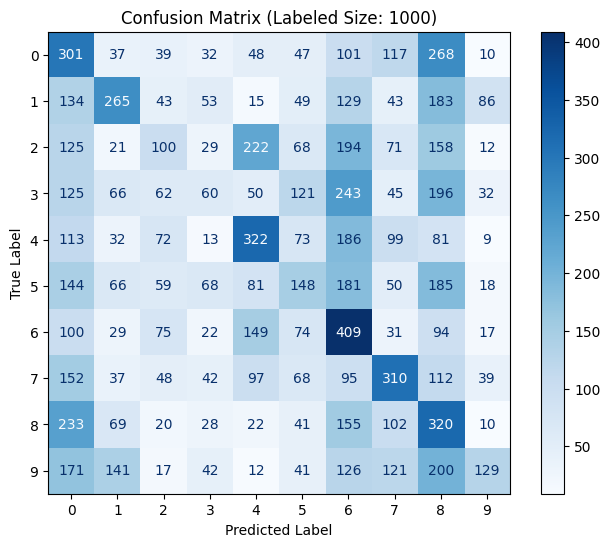

----------------------------------------------------------------
Starting training with 3000 labels and 47000 without labels...
Epoch [1/100], Average Loss: 2054.5008
Epoch [2/100], Average Loss: 1972.9021
Epoch [3/100], Average Loss: 1941.8969
Epoch [4/100], Average Loss: 1922.6217
Epoch [5/100], Average Loss: 1909.6446
Epoch [6/100], Average Loss: 1900.1068
Epoch [7/100], Average Loss: 1893.8336
Epoch [8/100], Average Loss: 1889.7498
Epoch [9/100], Average Loss: 1885.3824
Epoch [10/100], Average Loss: 1880.6511
Epoch [11/100], Average Loss: 1878.3891
Epoch [12/100], Average Loss: 1875.1718
Epoch [13/100], Average Loss: 1872.8002
Epoch [14/100], Average Loss: 1870.6842
Epoch [15/100], Average Loss: 1868.4365
Epoch [16/100], Average Loss: 1866.8513
Epoch [17/100], Average Loss: 1865.5985
Epoch [18/100], Average Loss: 1865.1348
Epoch [19/100], Average Loss: 1863.9838
Epoch [20/100], Average Loss: 1863.2350
Epoch [21/100], Average Loss: 1862.4978
Epoch [22/100], Average Loss: 1861.6419
E

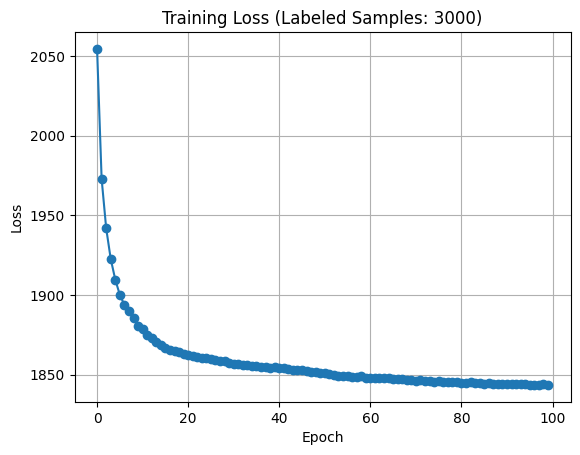

Files already downloaded and verified
Test Accuracy (3000 labels): 24.38%


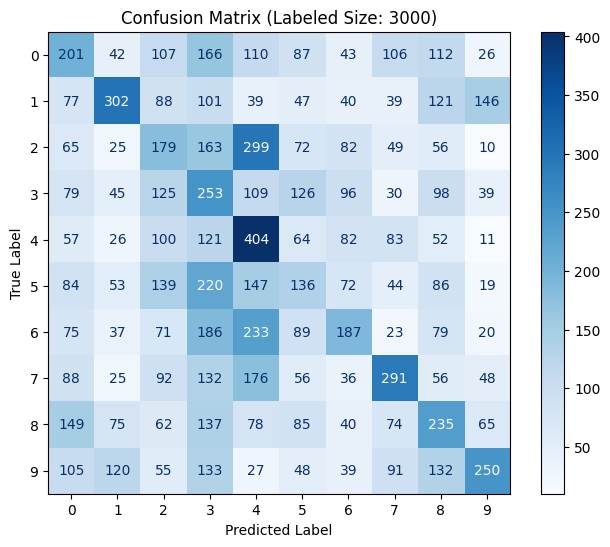

----------------------------------------------------------------


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters.
input_dim = 32 * 32 * 3   # CIFAR10 images
hidden_dim = 256
latent_dim = 50
num_classes = 10
learning_rate = 1e-3
batch_size = 256
num_epochs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

labels_list = [100, 1000, 3000] # Different label size

    # Create a semi-supervised split: We make the classes balanced in the supervised labels.

targets = train_dataset.targets
if not isinstance(targets, torch.Tensor):

    targets = torch.tensor(targets)

for labeled_size in labels_list:

    assert labeled_size % num_classes == 0, (
        f"labeled_size={labeled_size} not divisible by num_classes={num_classes}"
    )

    per_class = labeled_size // num_classes


    labeled_indices = []
    for c in range(num_classes):

        c_indices = (targets == c).nonzero(as_tuple=True)[0]

        c_indices = c_indices[torch.randperm(len(c_indices))]

        labeled_indices.extend(c_indices[:per_class].tolist())


    labeled_indices = set(labeled_indices)
    all_indices = set(range(len(train_dataset)))

    unlabeled_indices = list(all_indices - labeled_indices)
    labeled_indices = list(labeled_indices)

    labeled_dataset = Subset(train_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

    if labeled_size == 100:
        batch_size_labeled = 1
        batch_size = 499
    elif labeled_size == 1000:
        batch_size_labeled = 10
        batch_size = 490
    elif labeled_size == 3000:
        batch_size_labeled = 30
        batch_size = 470

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
    model = model.to(device)
    epoch_losses = []

    # Training loop
    print(f"Starting training with {labeled_size} labels and {len(train_dataset)-labeled_size} without labels...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        labeled_samples_count = 0
        unlabeled_samples_count = 0

        for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):

            num_batches += 1
            labeled_samples_count += x_l.size(0)
            unlabeled_samples_count += x_u.size(0)

            x_l = x_l.to(device)
            y_l = y_l.to(device)
            x_u = x_u.to(device)

            loss = model.train_step(x_l, y_l, x_u)
            total_loss += loss

        avg_loss = total_loss / (len(labeled_loader)+len(unlabeled_loader))
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    print(f"  Processed {num_batches} batches per epoch: {labeled_samples_count} labeled samples, {unlabeled_samples_count} unlabeled samples")

    # Plot training loss curve
    plt.figure()
    plt.plot(epoch_losses, marker='o')
    plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Evaluate on test data.
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            preds = model.predict(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
    print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')

    ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    print('----------------------------------------------------------------')




In [17]:
train_dataset[0][0].shape

torch.Size([3072])

Generating latent space visualization...


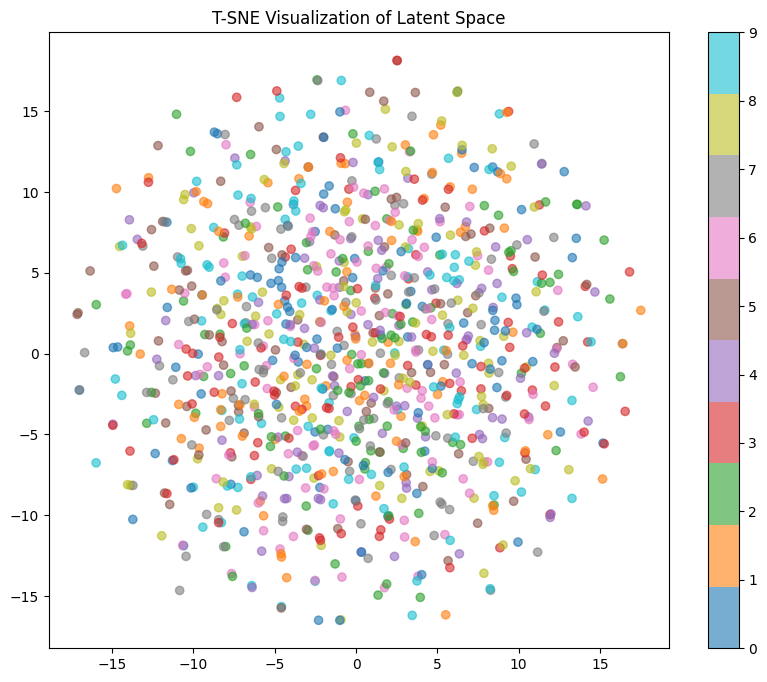

In [18]:
print("Generating latent space visualization...")
model.visualize_latent_tsne(test_loader)

Generating conditional samples...


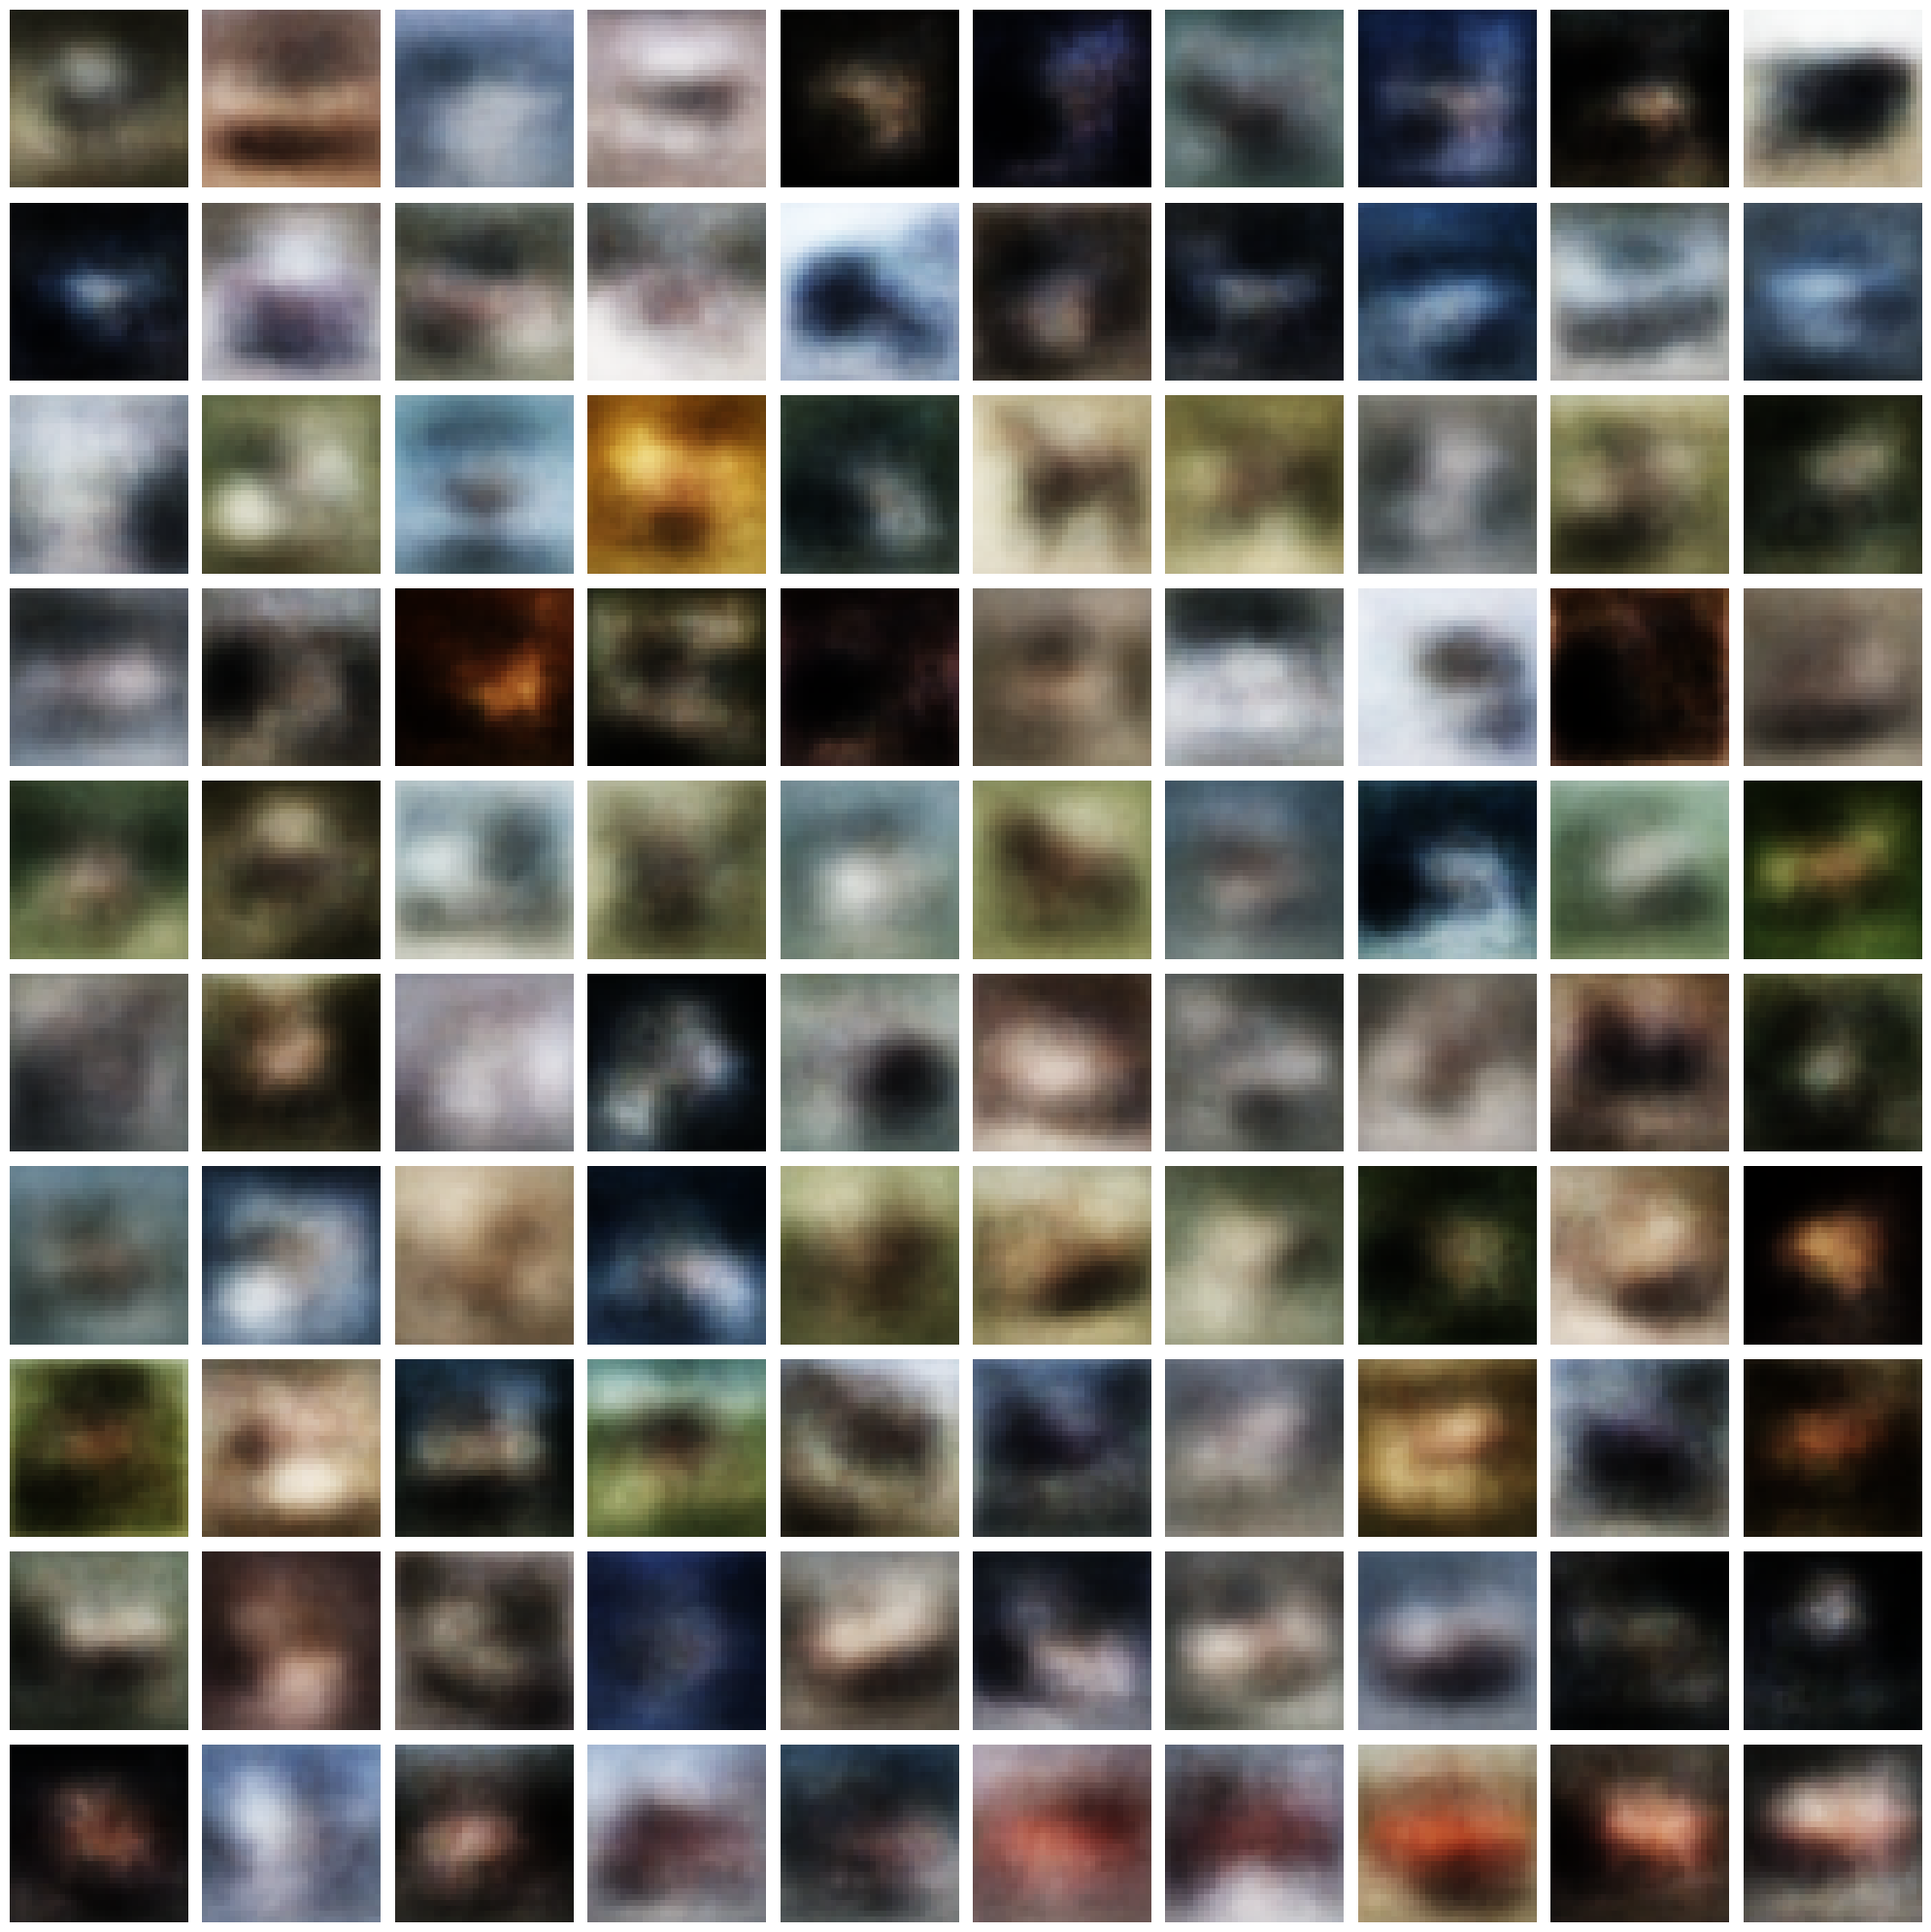

In [19]:
print("Generating conditional samples...")
model.generate_conditional_samples()